In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, utils, datasets
import numpy as np
from sklearn.metrics import confusion_matrix

import mlflow
import mlflow.tensorflow

Text(0.5, 1.0, '3')

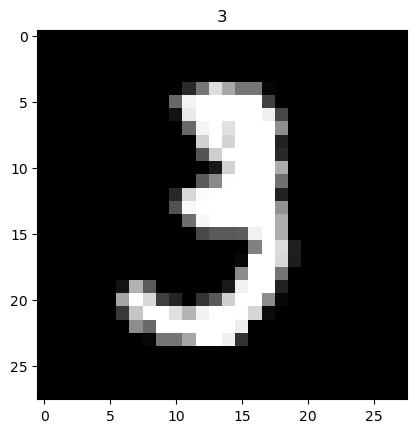

In [3]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
plt.imshow(X_train[10], cmap='gray')
plt.title(y_train[10])

In [5]:
print(X_train.shape)

(60000, 784)


In [6]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
print(X_train.shape)
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

(60000, 784)


In [7]:
# Reduzir dimensionalidade preservando 95% de sua variancia, para ocupar menos espaço. Cada instância terá pouco mais de 150 features, reduzindo 20% do tamanho
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95) #ou 154 componentes
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)

In [13]:
print(X_train.dtype)

uint8


In [14]:
X_train_reduced = X_train_reduced.astype('float32')
print(X_train_reduced.dtype)
X_test_reduced = X_test_reduced.astype('float32')
#X_train_recovered = pca.inverse_transform(X_train_reduced)
X_train_reduced /= 255
X_test_reduced /= 255

float32


In [15]:
#transformando target em dummy (onehotencoder)
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [18]:
y_train[10]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [ ]:
def train_nn(hidden_layers, neurons, activation_function_hidden, drop_out, epochs):
    mlflow.set_experiment('nnexperimento')

    with mlflow.start_run():
        mlflow.tensorflow.autolog()

        #registro de tags
        mlflow.set_tag('hidden_layers', hidden_layers)
        mlflow.set_tag('neurons', neurons)
        mlflow.set_tag('activation_function_hidden', activation_function_hidden)
        mlflow.set_tag('drop_out', drop_out)
        mlflow.set_tag('epochs', epochs)
        #https://www.tensorflow.org/guide/keras/sequential_model?hl=pt-br
        model = keras.Sequential()
        #primeira camada oculta + camada de entrada
        model.add(layers.Dense(units=neurons, activation=activation_function_hidden, input_dim=154))
        model.add(layers.Dropout(drop_out))

        #camadas ocultas adicionais com dropout
        for n in range(hidden_layers):
            model.add(layers.Dense(units=neurons, activation=activation_function_hidden))
            model.add(layers.Dropout(drop_out))

        #camada de saída com 10 saídas -  multiclasse
        model.add(layers.Dense(units=10, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        model.summary()

        histdata = model.fit(X_train_reduced, y_train, epochs=epochs, validation_data=(X_test_reduced, y_test))

        #graficos
        histdata.history.keys()
        loss = plt.plot(histdata.history['val_loss']) #diferenca entre predito e observado
        plt.savefig('loss.png')
        #plt.close()

        acc = plt.plot(histdata.history['val_accuracy']) #diferença entre erros e acertos
        plt.savefig('acc.png')

        #registrar artefatos
        mlflow.log_artifact('loss.png')
        mlflow.log_artifact('acc.png')        

        #info para execucao
        print('Modelo: ', mlflow.active_run().info.run_uuid)

        #mlflow.sklearn.log_model(model, 'modelnn')
    mlflow.end_run()

c:\Users\Josenalde\anaconda3\envs\tadsml\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,194 (12.48 KB)

 Trainable params: 3,194 (12.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
1865/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3960 - loss: 1.6544

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.3970 - loss: 1.6520 - val_accuracy: 0.5993 - val_loss: 1.2750
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7392 - loss: 0.8240 - val_accuracy: 0.5797 - val_loss: 1.4190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Modelo:  fcd04afc290f4017b380970b8b0b5003
🏃 View run bald-cow-379 at: http://127.0.0.1:5000/#/experiments/401661058853009166/runs/fcd04afc290f4017b380970b8b0b5003
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/401661058853009166


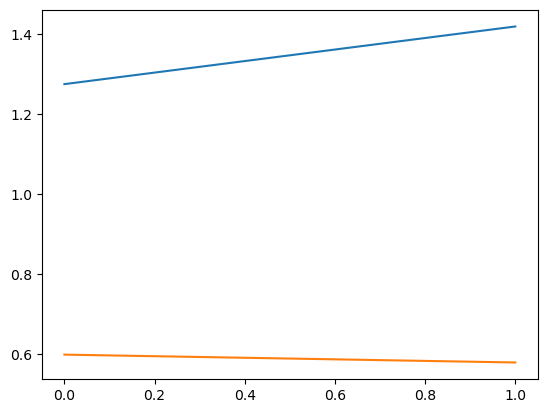

In [13]:
train_nn(2, 16,'relu',0.2,2)

In [27]:
"""
hidden_layers = [1, 2, 3]
neurons = [10,32,64]
activation = ['relu', 'tanh']
drop_out = [0.1, 0.2]
epochs = [5, 10, 20]

# 108 modelos

for layers in hidden_layers:
    for n in neurons:
        for act in activation:
            for drop in drop_out:
                for e in epochs:
                    train_nn(layers, n, act, drop, e)
"""

"\nhidden_layers = [1, 2, 3]\nneurons = [10,32,64]\nactivation = ['relu', 'tanh']\ndrop_out = [0.1, 0.2]\nepochs = [5, 10, 20]\n\n# 108 modelos\n\nfor layers in hidden_layers:\n    for n in neurons:\n        for act in activation:\n            for drop in drop_out:\n                for e in epochs:\n                    train_nn(layers, n, act, drop, e)\n"

#### Para servir o modelo
#### mlflow models serve --model-uri runs :/runid/log_name -p 2345